In [21]:
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch import nn

In [22]:
from loguru import logger
import wandb

In [23]:
DATA_ROOT = "../data/CAIA"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [24]:
WANDB_API_KEY = os.environ.get("WANDB_API_KEY")
wandb.login(key=WANDB_API_KEY)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

# I.Data

In [25]:
TARGET_SIZE = (720, 1280) # h, w
BATCH_SIZE = 512

Preprocess

In [26]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(degrees=2),
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

Load data

In [27]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        for label, class_dir in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_dir)
            for image_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, image_name))
                self.labels.append(label)
                
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [28]:
training_data = CustomImageDataset(root_dir=f"{DATA_ROOT}/train", transform=transform)
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

In [29]:
val_data = CustomImageDataset(root_dir=f"{DATA_ROOT}/val", transform=transform)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [30]:
test_data = CustomImageDataset(root_dir=f"{DATA_ROOT}/test", transform=transform)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

Visualize data

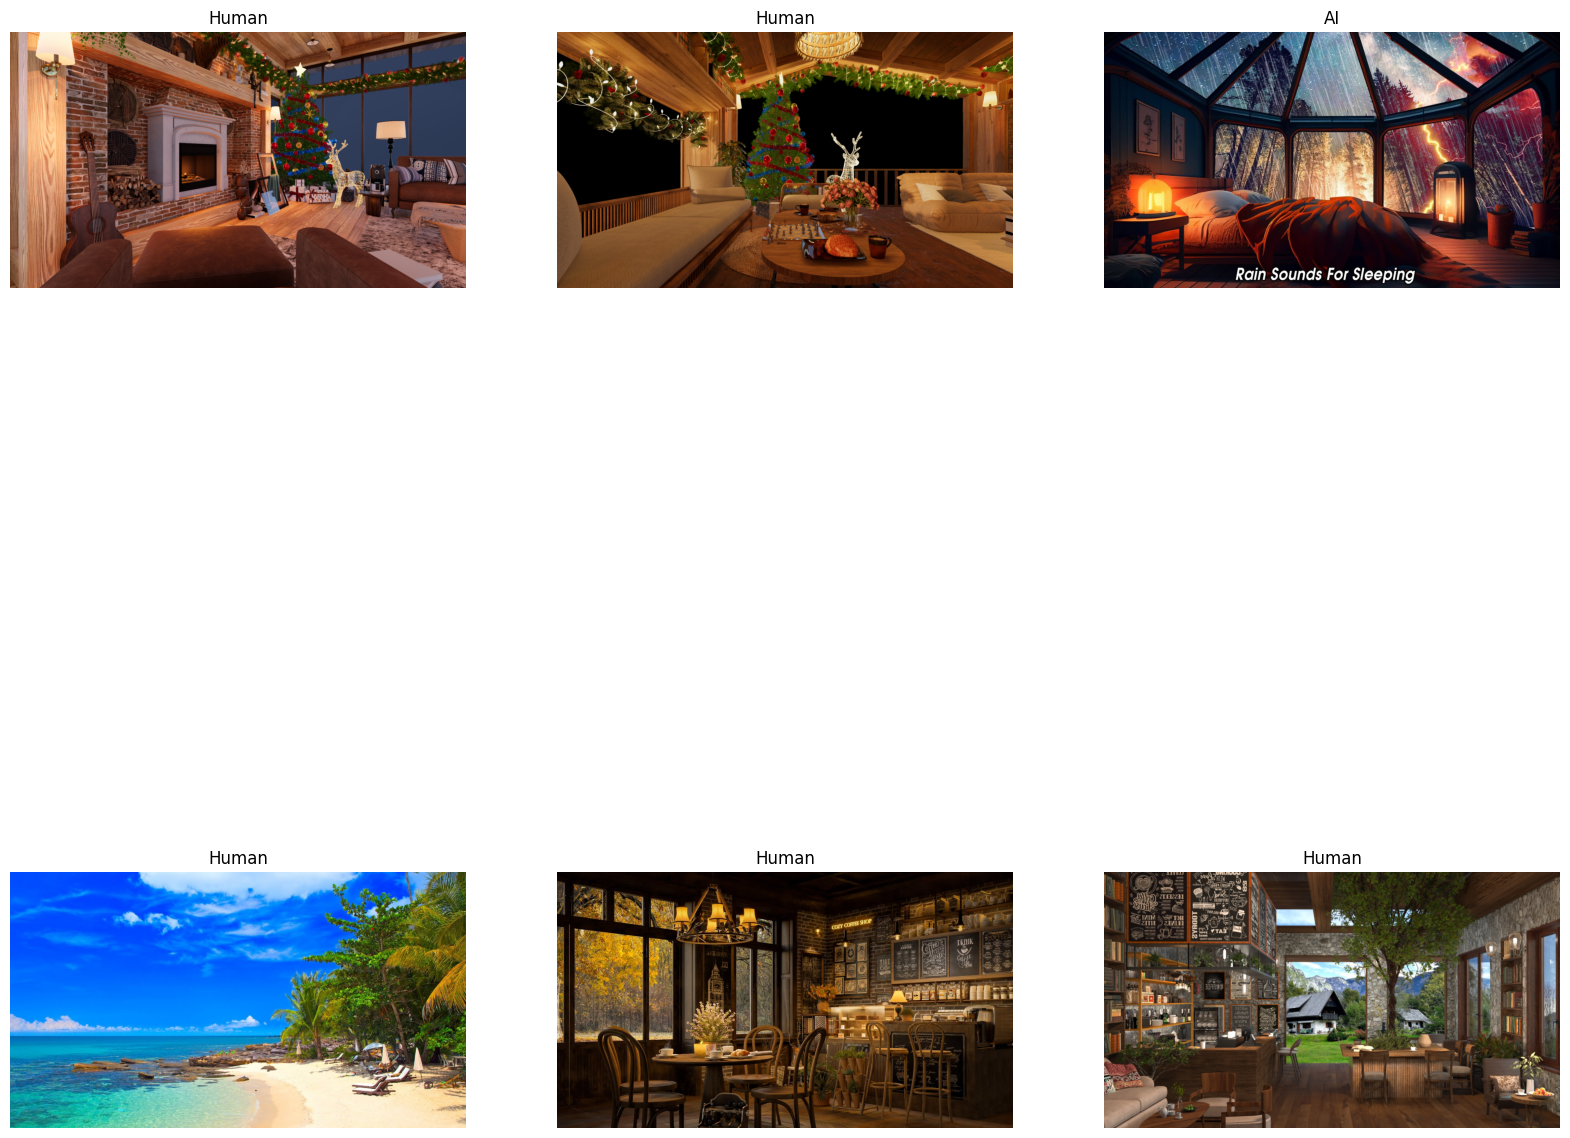

In [31]:
labels_map = {
    0: "Human",
    1: "AI",
}
figure = plt.figure(figsize=(20, 20))
cols, rows = 3, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))  # Chuyển đổi từ (C, H, W) sang (H, W, C)
    # img = (img * 0.5) + 0.5  # Undo normalization
    plt.imshow(img)

# II. Build model

In [32]:
weights = models.ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1
pretrained_model = models.vit_l_16(weights = weights)
for param in pretrained_model.parameters():
    param.requires_grad = False

In [33]:
class ArtClsModel(nn.Module):
    def __init__(self, pretrained_model) -> None:
        super(ArtClsModel, self).__init__()
        
        self.features = nn.Sequential(*list(pretrained_model.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(pretrained_model.heads.head.in_features),
            nn.Linear(pretrained_model.heads.head.in_features, 512),
            # nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        logits = self.classifier(x)
        return logits
    

In [34]:
model = ArtClsModel(pretrained_model).to(DEVICE)
# print(model)

params

In [35]:
# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

# III. Train

In [36]:
LEARNING_RATE = 1e-1
EPOCHS = 200
VAL_EPOCH = 10
TEST_EPOCH = 50

In [37]:
wandb.init(
    project="classification-model_ai-art",
    name="v0.39",
    config={
    "learning_rate": LEARNING_RATE,
    "pretraind_model": "vit_l_16",
    "dataset": "CAIA-dataset",
    "train_epochs": EPOCHS,
    "val_per_epochs": VAL_EPOCH,  
    "test_per_epochs": TEST_EPOCH,
    "batch_size": BATCH_SIZE,
    }
)


test_acc,▁
test_loss,▁
train_loss,▆▇▅▆▆▆▂▆▆▇▇▇▅▄▆▆▄▇▅▅▅▇▆█▆▇▅▇▆▇█▆▆▆▇▅▅▇▅▁
val_acc,▁▁
val_loss,█▁
test_acc,20.86957
test_loss,0.66463
train_loss,0.678
val_acc,37.80488
val_loss,0.67928


In [38]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)

In [39]:
def train_loop(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    for idx_batch, (X, y) in enumerate(dataloader):
        X, y = X.to(DEVICE), y.to(DEVICE)
        y = y.unsqueeze(1).float()
        # Compute prediction error
        pred = model(X)
        loss = criterion(pred, y)
        
        loss.backward()
        
        # show log
        loss, current = loss.item(), idx_batch * len(X)
        wandb.log({"train_loss": loss})
        
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        # Backpropagation
        optimizer.zero_grad()
        optimizer.step()
        
            
            
def val_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y = y.unsqueeze(1)
            pred = model(X)
            test_loss += criterion(pred, y.float()).item()
            correct += (pred.round() == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    wandb.log({"val_loss": test_loss, "val_acc": 100*correct})
    print("\n--------Val-------")
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    print("------------------\n")
            
def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y = y.unsqueeze(1)
            pred = model(X)
            test_loss += criterion(pred, y.float()).item()
            correct += (pred.round() == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    wandb.log({"test_loss": test_loss, "test_acc": 100*correct})
    print("\n-------Test-------")
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    print("------------------\n")

In [40]:
for t in range(EPOCHS):
    logger.info(f"Epoch {t+1}")
    train_loop(train_dataloader, model, criterion, optimizer)
    
    if t % VAL_EPOCH == 0:
        val_loop(val_dataloader, model, criterion)
    
    if t % TEST_EPOCH == 0:
        test_loop(test_dataloader, model, criterion)
wandb.finish()

2024-07-10 17:45:46.240 | INFO     | __main__:<module>:2 - Epoch 1


loss: 0.695348  [    0/ 1600]
loss: 0.690601  [  512/ 1600]
loss: 0.693274  [ 1024/ 1600]
loss: 0.695833  [  192/ 1600]

--------Val-------
Accuracy: 37.8%, Avg loss: 0.692861
------------------



2024-07-10 17:48:21.297 | INFO     | __main__:<module>:2 - Epoch 2



-------Test-------
Accuracy: 20.9%, Avg loss: 0.699093
------------------

loss: 0.693215  [    0/ 1600]
loss: 0.692440  [  512/ 1600]
loss: 0.695071  [ 1024/ 1600]


2024-07-10 17:50:34.099 | INFO     | __main__:<module>:2 - Epoch 3


loss: 0.682045  [  192/ 1600]
loss: 0.694135  [    0/ 1600]
loss: 0.691557  [  512/ 1600]
loss: 0.692940  [ 1024/ 1600]


2024-07-10 17:52:47.217 | INFO     | __main__:<module>:2 - Epoch 4


loss: 0.693375  [  192/ 1600]
loss: 0.690735  [    0/ 1600]
loss: 0.695199  [  512/ 1600]
loss: 0.694841  [ 1024/ 1600]


2024-07-10 17:55:00.235 | INFO     | __main__:<module>:2 - Epoch 5


loss: 0.679679  [  192/ 1600]
loss: 0.692457  [    0/ 1600]
loss: 0.692320  [  512/ 1600]
loss: 0.694762  [ 1024/ 1600]


2024-07-10 17:57:13.377 | INFO     | __main__:<module>:2 - Epoch 6


loss: 0.690573  [  192/ 1600]
loss: 0.693089  [    0/ 1600]
loss: 0.693773  [  512/ 1600]
loss: 0.690826  [ 1024/ 1600]


2024-07-10 17:59:26.361 | INFO     | __main__:<module>:2 - Epoch 7


loss: 0.706044  [  192/ 1600]
loss: 0.692234  [    0/ 1600]
loss: 0.692285  [  512/ 1600]
loss: 0.694637  [ 1024/ 1600]


2024-07-10 18:01:39.355 | INFO     | __main__:<module>:2 - Epoch 8


loss: 0.696023  [  192/ 1600]
loss: 0.694843  [    0/ 1600]
loss: 0.693241  [  512/ 1600]
loss: 0.690588  [ 1024/ 1600]


2024-07-10 18:03:52.063 | INFO     | __main__:<module>:2 - Epoch 9


loss: 0.698127  [  192/ 1600]
loss: 0.694162  [    0/ 1600]
loss: 0.692981  [  512/ 1600]
loss: 0.692269  [ 1024/ 1600]


2024-07-10 18:06:04.931 | INFO     | __main__:<module>:2 - Epoch 10


loss: 0.691787  [  192/ 1600]
loss: 0.691546  [    0/ 1600]
loss: 0.693269  [  512/ 1600]
loss: 0.695097  [ 1024/ 1600]


2024-07-10 18:08:17.626 | INFO     | __main__:<module>:2 - Epoch 11


loss: 0.685849  [  192/ 1600]
loss: 0.692541  [    0/ 1600]
loss: 0.693721  [  512/ 1600]
loss: 0.692915  [ 1024/ 1600]
loss: 0.695364  [  192/ 1600]


2024-07-10 18:10:38.670 | INFO     | __main__:<module>:2 - Epoch 12



--------Val-------
Accuracy: 37.8%, Avg loss: 0.692327
------------------

loss: 0.693447  [    0/ 1600]
loss: 0.691112  [  512/ 1600]
loss: 0.695187  [ 1024/ 1600]


2024-07-10 18:12:51.630 | INFO     | __main__:<module>:2 - Epoch 13


loss: 0.689137  [  192/ 1600]
loss: 0.694794  [    0/ 1600]
loss: 0.693064  [  512/ 1600]
loss: 0.691490  [ 1024/ 1600]


2024-07-10 18:15:04.534 | INFO     | __main__:<module>:2 - Epoch 14


loss: 0.692804  [  192/ 1600]
loss: 0.694224  [    0/ 1600]
loss: 0.693521  [  512/ 1600]
loss: 0.691809  [ 1024/ 1600]


2024-07-10 18:17:17.201 | INFO     | __main__:<module>:2 - Epoch 15


loss: 0.685824  [  192/ 1600]
loss: 0.695503  [    0/ 1600]
loss: 0.691412  [  512/ 1600]
loss: 0.691497  [ 1024/ 1600]


2024-07-10 18:19:30.045 | INFO     | __main__:<module>:2 - Epoch 16


loss: 0.702378  [  192/ 1600]
loss: 0.692430  [    0/ 1600]
loss: 0.693024  [  512/ 1600]
loss: 0.692347  [ 1024/ 1600]


2024-07-10 18:21:42.734 | INFO     | __main__:<module>:2 - Epoch 17


loss: 0.704081  [  192/ 1600]
loss: 0.695086  [    0/ 1600]
loss: 0.690572  [  512/ 1600]
loss: 0.693813  [ 1024/ 1600]


2024-07-10 18:23:55.597 | INFO     | __main__:<module>:2 - Epoch 18


loss: 0.693324  [  192/ 1600]
loss: 0.695326  [    0/ 1600]
loss: 0.691758  [  512/ 1600]
loss: 0.692264  [ 1024/ 1600]


2024-07-10 18:26:08.341 | INFO     | __main__:<module>:2 - Epoch 19


loss: 0.689986  [  192/ 1600]
loss: 0.695888  [    0/ 1600]
loss: 0.692750  [  512/ 1600]
loss: 0.690751  [ 1024/ 1600]


2024-07-10 18:28:21.765 | INFO     | __main__:<module>:2 - Epoch 20


loss: 0.691439  [  192/ 1600]
loss: 0.690684  [    0/ 1600]
loss: 0.693495  [  512/ 1600]
loss: 0.694762  [ 1024/ 1600]


2024-07-10 18:30:34.677 | INFO     | __main__:<module>:2 - Epoch 21


loss: 0.694272  [  192/ 1600]
loss: 0.696502  [    0/ 1600]
loss: 0.691411  [  512/ 1600]
loss: 0.691785  [ 1024/ 1600]
loss: 0.687903  [  192/ 1600]


2024-07-10 18:32:55.593 | INFO     | __main__:<module>:2 - Epoch 22



--------Val-------
Accuracy: 37.8%, Avg loss: 0.693290
------------------

loss: 0.694369  [    0/ 1600]
loss: 0.692977  [  512/ 1600]
loss: 0.691747  [ 1024/ 1600]


2024-07-10 18:35:08.082 | INFO     | __main__:<module>:2 - Epoch 23


loss: 0.694567  [  192/ 1600]
loss: 0.690238  [    0/ 1600]
loss: 0.692850  [  512/ 1600]
loss: 0.695005  [ 1024/ 1600]


2024-07-10 18:37:21.264 | INFO     | __main__:<module>:2 - Epoch 24


loss: 0.700977  [  192/ 1600]
loss: 0.693606  [    0/ 1600]
loss: 0.692432  [  512/ 1600]
loss: 0.692842  [ 1024/ 1600]


2024-07-10 18:39:34.157 | INFO     | __main__:<module>:2 - Epoch 25


loss: 0.693374  [  192/ 1600]
loss: 0.692502  [    0/ 1600]
loss: 0.691854  [  512/ 1600]
loss: 0.694203  [ 1024/ 1600]


2024-07-10 18:41:47.252 | INFO     | __main__:<module>:2 - Epoch 26


loss: 0.695004  [  192/ 1600]
loss: 0.692107  [    0/ 1600]
loss: 0.694323  [  512/ 1600]
loss: 0.693250  [ 1024/ 1600]


2024-07-10 18:44:00.229 | INFO     | __main__:<module>:2 - Epoch 27


loss: 0.686943  [  192/ 1600]
loss: 0.693052  [    0/ 1600]
loss: 0.695703  [  512/ 1600]
loss: 0.689914  [ 1024/ 1600]


2024-07-10 18:46:13.435 | INFO     | __main__:<module>:2 - Epoch 28


loss: 0.702470  [  192/ 1600]
loss: 0.693483  [    0/ 1600]
loss: 0.693874  [  512/ 1600]
loss: 0.691381  [ 1024/ 1600]


2024-07-10 18:48:25.957 | INFO     | __main__:<module>:2 - Epoch 29


loss: 0.695553  [  192/ 1600]
loss: 0.691659  [    0/ 1600]
loss: 0.692521  [  512/ 1600]
loss: 0.695180  [ 1024/ 1600]


2024-07-10 18:50:38.492 | INFO     | __main__:<module>:2 - Epoch 30


loss: 0.690700  [  192/ 1600]
loss: 0.693326  [    0/ 1600]
loss: 0.693969  [  512/ 1600]
loss: 0.692123  [ 1024/ 1600]


2024-07-10 18:52:51.276 | INFO     | __main__:<module>:2 - Epoch 31


loss: 0.691745  [  192/ 1600]
loss: 0.692955  [    0/ 1600]
loss: 0.692867  [  512/ 1600]
loss: 0.693486  [ 1024/ 1600]
loss: 0.692903  [  192/ 1600]


2024-07-10 18:55:12.548 | INFO     | __main__:<module>:2 - Epoch 32



--------Val-------
Accuracy: 37.8%, Avg loss: 0.692552
------------------

loss: 0.694653  [    0/ 1600]
loss: 0.694489  [  512/ 1600]
loss: 0.692211  [ 1024/ 1600]


2024-07-10 18:57:25.305 | INFO     | __main__:<module>:2 - Epoch 33


loss: 0.681826  [  192/ 1600]
loss: 0.692308  [    0/ 1600]
loss: 0.692371  [  512/ 1600]
loss: 0.694130  [ 1024/ 1600]


2024-07-10 18:59:38.086 | INFO     | __main__:<module>:2 - Epoch 34


loss: 0.695643  [  192/ 1600]
loss: 0.692780  [    0/ 1600]
loss: 0.690022  [  512/ 1600]
loss: 0.695801  [ 1024/ 1600]


2024-07-10 19:01:50.699 | INFO     | __main__:<module>:2 - Epoch 35


loss: 0.698419  [  192/ 1600]
loss: 0.689846  [    0/ 1600]
loss: 0.695677  [  512/ 1600]
loss: 0.694622  [ 1024/ 1600]


2024-07-10 19:04:03.366 | INFO     | __main__:<module>:2 - Epoch 36


loss: 0.689187  [  192/ 1600]
loss: 0.692619  [    0/ 1600]
loss: 0.691973  [  512/ 1600]
loss: 0.695565  [ 1024/ 1600]


2024-07-10 19:06:16.236 | INFO     | __main__:<module>:2 - Epoch 37


loss: 0.688825  [  192/ 1600]
loss: 0.694060  [    0/ 1600]
loss: 0.690383  [  512/ 1600]
loss: 0.695430  [ 1024/ 1600]


2024-07-10 19:08:29.005 | INFO     | __main__:<module>:2 - Epoch 38


loss: 0.686716  [  192/ 1600]
loss: 0.692126  [    0/ 1600]
loss: 0.692323  [  512/ 1600]
loss: 0.694228  [ 1024/ 1600]


2024-07-10 19:10:42.045 | INFO     | __main__:<module>:2 - Epoch 39


loss: 0.695149  [  192/ 1600]
loss: 0.693808  [    0/ 1600]
loss: 0.694034  [  512/ 1600]
loss: 0.691766  [ 1024/ 1600]


2024-07-10 19:12:54.831 | INFO     | __main__:<module>:2 - Epoch 40


loss: 0.689684  [  192/ 1600]
loss: 0.692234  [    0/ 1600]
loss: 0.694432  [  512/ 1600]
loss: 0.694387  [ 1024/ 1600]


2024-07-10 19:15:07.544 | INFO     | __main__:<module>:2 - Epoch 41


loss: 0.680867  [  192/ 1600]
loss: 0.693498  [    0/ 1600]
loss: 0.694253  [  512/ 1600]
loss: 0.692468  [ 1024/ 1600]
loss: 0.686730  [  192/ 1600]


2024-07-10 19:17:28.857 | INFO     | __main__:<module>:2 - Epoch 42



--------Val-------
Accuracy: 37.8%, Avg loss: 0.692151
------------------

loss: 0.694270  [    0/ 1600]
loss: 0.692123  [  512/ 1600]
loss: 0.693320  [ 1024/ 1600]


2024-07-10 19:19:41.796 | INFO     | __main__:<module>:2 - Epoch 43


loss: 0.690202  [  192/ 1600]
loss: 0.695248  [    0/ 1600]
loss: 0.692704  [  512/ 1600]
loss: 0.692906  [ 1024/ 1600]


2024-07-10 19:21:54.611 | INFO     | __main__:<module>:2 - Epoch 44


loss: 0.677664  [  192/ 1600]
loss: 0.694523  [    0/ 1600]
loss: 0.692039  [  512/ 1600]
loss: 0.692137  [ 1024/ 1600]


2024-07-10 19:24:07.432 | INFO     | __main__:<module>:2 - Epoch 45


loss: 0.695929  [  192/ 1600]
loss: 0.693479  [    0/ 1600]
loss: 0.692545  [  512/ 1600]
loss: 0.693048  [ 1024/ 1600]


2024-07-10 19:26:20.343 | INFO     | __main__:<module>:2 - Epoch 46


loss: 0.695141  [  192/ 1600]
loss: 0.692911  [    0/ 1600]
loss: 0.692919  [  512/ 1600]
loss: 0.694116  [ 1024/ 1600]


2024-07-10 19:28:33.171 | INFO     | __main__:<module>:2 - Epoch 47


loss: 0.686593  [  192/ 1600]
loss: 0.693763  [    0/ 1600]
loss: 0.692305  [  512/ 1600]
loss: 0.693418  [ 1024/ 1600]


2024-07-10 19:30:46.248 | INFO     | __main__:<module>:2 - Epoch 48


loss: 0.690044  [  192/ 1600]
loss: 0.693626  [    0/ 1600]
loss: 0.693628  [  512/ 1600]
loss: 0.691412  [ 1024/ 1600]


2024-07-10 19:32:59.164 | INFO     | __main__:<module>:2 - Epoch 49


loss: 0.698231  [  192/ 1600]
loss: 0.693045  [    0/ 1600]
loss: 0.692482  [  512/ 1600]
loss: 0.694157  [ 1024/ 1600]


2024-07-10 19:35:11.845 | INFO     | __main__:<module>:2 - Epoch 50


loss: 0.690618  [  192/ 1600]
loss: 0.692646  [    0/ 1600]
loss: 0.693892  [  512/ 1600]
loss: 0.693089  [ 1024/ 1600]


2024-07-10 19:37:24.580 | INFO     | __main__:<module>:2 - Epoch 51


loss: 0.688846  [  192/ 1600]
loss: 0.693740  [    0/ 1600]
loss: 0.691631  [  512/ 1600]
loss: 0.693506  [ 1024/ 1600]
loss: 0.695176  [  192/ 1600]

--------Val-------
Accuracy: 37.8%, Avg loss: 0.692728
------------------



2024-07-10 19:39:59.131 | INFO     | __main__:<module>:2 - Epoch 52



-------Test-------
Accuracy: 20.9%, Avg loss: 0.698917
------------------

loss: 0.693840  [    0/ 1600]
loss: 0.691429  [  512/ 1600]
loss: 0.693911  [ 1024/ 1600]


2024-07-10 19:42:11.849 | INFO     | __main__:<module>:2 - Epoch 53


loss: 0.696113  [  192/ 1600]
loss: 0.693924  [    0/ 1600]
loss: 0.695441  [  512/ 1600]
loss: 0.691345  [ 1024/ 1600]


2024-07-10 19:44:24.458 | INFO     | __main__:<module>:2 - Epoch 54


loss: 0.680579  [  192/ 1600]
loss: 0.695220  [    0/ 1600]
loss: 0.692597  [  512/ 1600]
loss: 0.691298  [ 1024/ 1600]


2024-07-10 19:46:37.354 | INFO     | __main__:<module>:2 - Epoch 55


loss: 0.694897  [  192/ 1600]
loss: 0.694171  [    0/ 1600]
loss: 0.696588  [  512/ 1600]
loss: 0.689718  [ 1024/ 1600]


2024-07-10 19:48:50.053 | INFO     | __main__:<module>:2 - Epoch 56


loss: 0.686688  [  192/ 1600]
loss: 0.693440  [    0/ 1600]
loss: 0.694185  [  512/ 1600]
loss: 0.691938  [ 1024/ 1600]


2024-07-10 19:51:02.809 | INFO     | __main__:<module>:2 - Epoch 57


loss: 0.687078  [  192/ 1600]
loss: 0.697042  [    0/ 1600]
loss: 0.689673  [  512/ 1600]
loss: 0.692682  [ 1024/ 1600]


2024-07-10 19:53:15.557 | INFO     | __main__:<module>:2 - Epoch 58


loss: 0.694664  [  192/ 1600]
loss: 0.692261  [    0/ 1600]
loss: 0.692048  [  512/ 1600]
loss: 0.695310  [ 1024/ 1600]


2024-07-10 19:55:28.104 | INFO     | __main__:<module>:2 - Epoch 59


loss: 0.687842  [  192/ 1600]
loss: 0.692669  [    0/ 1600]
loss: 0.694098  [  512/ 1600]
loss: 0.693597  [ 1024/ 1600]


2024-07-10 19:57:41.012 | INFO     | __main__:<module>:2 - Epoch 60


loss: 0.681618  [  192/ 1600]
loss: 0.693458  [    0/ 1600]
loss: 0.693286  [  512/ 1600]
loss: 0.693178  [ 1024/ 1600]


2024-07-10 19:59:53.593 | INFO     | __main__:<module>:2 - Epoch 61


loss: 0.688825  [  192/ 1600]
loss: 0.695330  [    0/ 1600]
loss: 0.692211  [  512/ 1600]
loss: 0.691359  [ 1024/ 1600]
loss: 0.694800  [  192/ 1600]


2024-07-10 20:02:14.860 | INFO     | __main__:<module>:2 - Epoch 62



--------Val-------
Accuracy: 37.8%, Avg loss: 0.692767
------------------

loss: 0.689243  [    0/ 1600]
loss: 0.692415  [  512/ 1600]
loss: 0.696986  [ 1024/ 1600]


2024-07-10 20:04:27.530 | INFO     | __main__:<module>:2 - Epoch 63


loss: 0.698593  [  192/ 1600]
loss: 0.694059  [    0/ 1600]
loss: 0.693250  [  512/ 1600]
loss: 0.692749  [ 1024/ 1600]


2024-07-10 20:06:40.753 | INFO     | __main__:<module>:2 - Epoch 64


loss: 0.685897  [  192/ 1600]
loss: 0.693867  [    0/ 1600]
loss: 0.693253  [  512/ 1600]
loss: 0.692417  [ 1024/ 1600]


2024-07-10 20:08:53.415 | INFO     | __main__:<module>:2 - Epoch 65


loss: 0.687463  [  192/ 1600]
loss: 0.693267  [    0/ 1600]
loss: 0.690832  [  512/ 1600]
loss: 0.695825  [ 1024/ 1600]


2024-07-10 20:11:05.996 | INFO     | __main__:<module>:2 - Epoch 66


loss: 0.688593  [  192/ 1600]
loss: 0.689389  [    0/ 1600]
loss: 0.696636  [  512/ 1600]
loss: 0.693483  [ 1024/ 1600]


2024-07-10 20:13:18.615 | INFO     | __main__:<module>:2 - Epoch 67


loss: 0.696505  [  192/ 1600]
loss: 0.691432  [    0/ 1600]
loss: 0.691893  [  512/ 1600]
loss: 0.696558  [ 1024/ 1600]


2024-07-10 20:15:31.662 | INFO     | __main__:<module>:2 - Epoch 68


loss: 0.690754  [  192/ 1600]
loss: 0.694787  [    0/ 1600]
loss: 0.694041  [  512/ 1600]
loss: 0.691143  [ 1024/ 1600]


2024-07-10 20:17:44.479 | INFO     | __main__:<module>:2 - Epoch 69


loss: 0.688070  [  192/ 1600]
loss: 0.690203  [    0/ 1600]
loss: 0.695072  [  512/ 1600]
loss: 0.695246  [ 1024/ 1600]


2024-07-10 20:19:56.940 | INFO     | __main__:<module>:2 - Epoch 70


loss: 0.685796  [  192/ 1600]
loss: 0.690850  [    0/ 1600]
loss: 0.695488  [  512/ 1600]
loss: 0.693615  [ 1024/ 1600]


2024-07-10 20:22:09.392 | INFO     | __main__:<module>:2 - Epoch 71


loss: 0.686669  [  192/ 1600]
loss: 0.693558  [    0/ 1600]
loss: 0.690840  [  512/ 1600]
loss: 0.694053  [ 1024/ 1600]
loss: 0.699375  [  192/ 1600]


2024-07-10 20:24:30.727 | INFO     | __main__:<module>:2 - Epoch 72



--------Val-------
Accuracy: 37.8%, Avg loss: 0.693577
------------------

loss: 0.693698  [    0/ 1600]
loss: 0.692772  [  512/ 1600]
loss: 0.693255  [ 1024/ 1600]


2024-07-10 20:26:43.146 | INFO     | __main__:<module>:2 - Epoch 73


loss: 0.687150  [  192/ 1600]
loss: 0.692471  [    0/ 1600]
loss: 0.691673  [  512/ 1600]
loss: 0.694872  [ 1024/ 1600]


2024-07-10 20:28:55.848 | INFO     | __main__:<module>:2 - Epoch 74


loss: 0.695678  [  192/ 1600]
loss: 0.694221  [    0/ 1600]
loss: 0.690619  [  512/ 1600]
loss: 0.694471  [ 1024/ 1600]


2024-07-10 20:31:08.601 | INFO     | __main__:<module>:2 - Epoch 75


loss: 0.695043  [  192/ 1600]
loss: 0.691268  [    0/ 1600]
loss: 0.694199  [  512/ 1600]
loss: 0.694091  [ 1024/ 1600]


2024-07-10 20:33:21.159 | INFO     | __main__:<module>:2 - Epoch 76


loss: 0.689260  [  192/ 1600]
loss: 0.693475  [    0/ 1600]
loss: 0.692779  [  512/ 1600]
loss: 0.692321  [ 1024/ 1600]


2024-07-10 20:35:34.021 | INFO     | __main__:<module>:2 - Epoch 77


loss: 0.699408  [  192/ 1600]
loss: 0.691670  [    0/ 1600]
loss: 0.692584  [  512/ 1600]
loss: 0.695726  [ 1024/ 1600]


2024-07-10 20:37:46.927 | INFO     | __main__:<module>:2 - Epoch 78


loss: 0.687557  [  192/ 1600]
loss: 0.691757  [    0/ 1600]
loss: 0.689829  [  512/ 1600]
loss: 0.695924  [ 1024/ 1600]


2024-07-10 20:39:59.485 | INFO     | __main__:<module>:2 - Epoch 79


loss: 0.707920  [  192/ 1600]
loss: 0.693452  [    0/ 1600]
loss: 0.693083  [  512/ 1600]
loss: 0.693723  [ 1024/ 1600]


2024-07-10 20:42:12.439 | INFO     | __main__:<module>:2 - Epoch 80


loss: 0.687195  [  192/ 1600]
loss: 0.694518  [    0/ 1600]
loss: 0.693890  [  512/ 1600]
loss: 0.690779  [ 1024/ 1600]


2024-07-10 20:44:25.296 | INFO     | __main__:<module>:2 - Epoch 81


loss: 0.696367  [  192/ 1600]
loss: 0.691402  [    0/ 1600]
loss: 0.692554  [  512/ 1600]
loss: 0.694706  [ 1024/ 1600]
loss: 0.700154  [  192/ 1600]


2024-07-10 20:46:46.559 | INFO     | __main__:<module>:2 - Epoch 82



--------Val-------
Accuracy: 37.8%, Avg loss: 0.692710
------------------

loss: 0.695342  [    0/ 1600]
loss: 0.692585  [  512/ 1600]
loss: 0.690876  [ 1024/ 1600]


2024-07-10 20:48:59.097 | INFO     | __main__:<module>:2 - Epoch 83


loss: 0.695153  [  192/ 1600]
loss: 0.694470  [    0/ 1600]
loss: 0.691162  [  512/ 1600]
loss: 0.692931  [ 1024/ 1600]


2024-07-10 20:51:11.889 | INFO     | __main__:<module>:2 - Epoch 84


loss: 0.697739  [  192/ 1600]
loss: 0.697081  [    0/ 1600]
loss: 0.688441  [  512/ 1600]
loss: 0.693956  [ 1024/ 1600]


2024-07-10 20:53:24.635 | INFO     | __main__:<module>:2 - Epoch 85


loss: 0.693076  [  192/ 1600]
loss: 0.693754  [    0/ 1600]
loss: 0.692881  [  512/ 1600]
loss: 0.693114  [ 1024/ 1600]


2024-07-10 20:55:37.724 | INFO     | __main__:<module>:2 - Epoch 86


loss: 0.689327  [  192/ 1600]
loss: 0.692552  [    0/ 1600]
loss: 0.693079  [  512/ 1600]
loss: 0.693926  [ 1024/ 1600]


2024-07-10 20:57:50.773 | INFO     | __main__:<module>:2 - Epoch 87


loss: 0.690519  [  192/ 1600]
loss: 0.695138  [    0/ 1600]
loss: 0.691502  [  512/ 1600]
loss: 0.692460  [ 1024/ 1600]


2024-07-10 21:00:03.690 | INFO     | __main__:<module>:2 - Epoch 88


loss: 0.695731  [  192/ 1600]
loss: 0.693730  [    0/ 1600]
loss: 0.690960  [  512/ 1600]
loss: 0.694614  [ 1024/ 1600]


2024-07-10 21:02:16.956 | INFO     | __main__:<module>:2 - Epoch 89


loss: 0.692647  [  192/ 1600]
loss: 0.692305  [    0/ 1600]
loss: 0.693536  [  512/ 1600]
loss: 0.692586  [ 1024/ 1600]


2024-07-10 21:04:29.498 | INFO     | __main__:<module>:2 - Epoch 90


loss: 0.700613  [  192/ 1600]
loss: 0.692066  [    0/ 1600]
loss: 0.691104  [  512/ 1600]
loss: 0.695445  [ 1024/ 1600]


2024-07-10 21:06:42.020 | INFO     | __main__:<module>:2 - Epoch 91


loss: 0.695510  [  192/ 1600]
loss: 0.695064  [    0/ 1600]
loss: 0.693400  [  512/ 1600]
loss: 0.690999  [ 1024/ 1600]
loss: 0.691057  [  192/ 1600]


2024-07-10 21:09:03.145 | INFO     | __main__:<module>:2 - Epoch 92



--------Val-------
Accuracy: 37.8%, Avg loss: 0.693269
------------------

loss: 0.690823  [    0/ 1600]
loss: 0.695016  [  512/ 1600]
loss: 0.693308  [ 1024/ 1600]


2024-07-10 21:11:16.279 | INFO     | __main__:<module>:2 - Epoch 93


loss: 0.694555  [  192/ 1600]
loss: 0.694564  [    0/ 1600]
loss: 0.692519  [  512/ 1600]
loss: 0.692822  [ 1024/ 1600]


2024-07-10 21:13:28.870 | INFO     | __main__:<module>:2 - Epoch 94


loss: 0.687123  [  192/ 1600]
loss: 0.693743  [    0/ 1600]
loss: 0.692675  [  512/ 1600]
loss: 0.692360  [ 1024/ 1600]


2024-07-10 21:15:41.511 | INFO     | __main__:<module>:2 - Epoch 95


loss: 0.696940  [  192/ 1600]
loss: 0.692456  [    0/ 1600]
loss: 0.693507  [  512/ 1600]
loss: 0.694977  [ 1024/ 1600]


2024-07-10 21:17:54.416 | INFO     | __main__:<module>:2 - Epoch 96


loss: 0.678246  [  192/ 1600]
loss: 0.690679  [    0/ 1600]
loss: 0.694637  [  512/ 1600]
loss: 0.693155  [ 1024/ 1600]


2024-07-10 21:20:07.327 | INFO     | __main__:<module>:2 - Epoch 97


loss: 0.695619  [  192/ 1600]
loss: 0.694049  [    0/ 1600]
loss: 0.694804  [  512/ 1600]
loss: 0.690779  [ 1024/ 1600]


2024-07-10 21:22:20.078 | INFO     | __main__:<module>:2 - Epoch 98


loss: 0.688526  [  192/ 1600]
loss: 0.692757  [    0/ 1600]
loss: 0.692832  [  512/ 1600]
loss: 0.694435  [ 1024/ 1600]


2024-07-10 21:24:32.954 | INFO     | __main__:<module>:2 - Epoch 99


loss: 0.687499  [  192/ 1600]
loss: 0.694351  [    0/ 1600]
loss: 0.693412  [  512/ 1600]
loss: 0.690977  [ 1024/ 1600]


2024-07-10 21:26:45.570 | INFO     | __main__:<module>:2 - Epoch 100


loss: 0.697997  [  192/ 1600]
loss: 0.696414  [    0/ 1600]
loss: 0.690043  [  512/ 1600]
loss: 0.692818  [ 1024/ 1600]


2024-07-10 21:28:58.487 | INFO     | __main__:<module>:2 - Epoch 101


loss: 0.692090  [  192/ 1600]
loss: 0.690530  [    0/ 1600]
loss: 0.694221  [  512/ 1600]
loss: 0.693392  [ 1024/ 1600]
loss: 0.699302  [  192/ 1600]

--------Val-------
Accuracy: 37.8%, Avg loss: 0.692622
------------------



2024-07-10 21:31:33.281 | INFO     | __main__:<module>:2 - Epoch 102



-------Test-------
Accuracy: 20.9%, Avg loss: 0.699080
------------------

loss: 0.695147  [    0/ 1600]
loss: 0.693722  [  512/ 1600]
loss: 0.691437  [ 1024/ 1600]


2024-07-10 21:33:46.097 | INFO     | __main__:<module>:2 - Epoch 103


loss: 0.685517  [  192/ 1600]
loss: 0.690474  [    0/ 1600]
loss: 0.694262  [  512/ 1600]
loss: 0.695675  [ 1024/ 1600]


2024-07-10 21:35:58.829 | INFO     | __main__:<module>:2 - Epoch 104


loss: 0.688369  [  192/ 1600]
loss: 0.691823  [    0/ 1600]
loss: 0.694899  [  512/ 1600]
loss: 0.692637  [ 1024/ 1600]


2024-07-10 21:38:12.193 | INFO     | __main__:<module>:2 - Epoch 105


loss: 0.693874  [  192/ 1600]
loss: 0.694020  [    0/ 1600]
loss: 0.692062  [  512/ 1600]
loss: 0.693160  [ 1024/ 1600]


2024-07-10 21:40:25.016 | INFO     | __main__:<module>:2 - Epoch 106


loss: 0.690165  [  192/ 1600]
loss: 0.696391  [    0/ 1600]
loss: 0.690672  [  512/ 1600]
loss: 0.691934  [ 1024/ 1600]


2024-07-10 21:42:38.380 | INFO     | __main__:<module>:2 - Epoch 107


loss: 0.696726  [  192/ 1600]
loss: 0.693584  [    0/ 1600]
loss: 0.691336  [  512/ 1600]
loss: 0.693267  [ 1024/ 1600]


2024-07-10 21:44:51.618 | INFO     | __main__:<module>:2 - Epoch 108


loss: 0.699666  [  192/ 1600]
loss: 0.695413  [    0/ 1600]
loss: 0.693643  [  512/ 1600]
loss: 0.689815  [ 1024/ 1600]


2024-07-10 21:47:04.745 | INFO     | __main__:<module>:2 - Epoch 109


loss: 0.697453  [  192/ 1600]
loss: 0.695607  [    0/ 1600]
loss: 0.690287  [  512/ 1600]
loss: 0.694358  [ 1024/ 1600]


2024-07-10 21:49:17.397 | INFO     | __main__:<module>:2 - Epoch 110


loss: 0.686142  [  192/ 1600]
loss: 0.692753  [    0/ 1600]
loss: 0.695656  [  512/ 1600]
loss: 0.690010  [ 1024/ 1600]


2024-07-10 21:51:30.133 | INFO     | __main__:<module>:2 - Epoch 111


loss: 0.701082  [  192/ 1600]
loss: 0.692835  [    0/ 1600]
loss: 0.694662  [  512/ 1600]
loss: 0.692110  [ 1024/ 1600]
loss: 0.689344  [  192/ 1600]


2024-07-10 21:53:51.681 | INFO     | __main__:<module>:2 - Epoch 112



--------Val-------
Accuracy: 37.8%, Avg loss: 0.692530
------------------

loss: 0.690778  [    0/ 1600]
loss: 0.693620  [  512/ 1600]
loss: 0.694448  [ 1024/ 1600]


2024-07-10 21:56:05.094 | INFO     | __main__:<module>:2 - Epoch 113


loss: 0.689444  [  192/ 1600]
loss: 0.690272  [    0/ 1600]
loss: 0.696503  [  512/ 1600]
loss: 0.692440  [ 1024/ 1600]


2024-07-10 21:58:17.803 | INFO     | __main__:<module>:2 - Epoch 114


loss: 0.697306  [  192/ 1600]
loss: 0.691296  [    0/ 1600]
loss: 0.694783  [  512/ 1600]
loss: 0.693531  [ 1024/ 1600]


2024-07-10 22:00:30.658 | INFO     | __main__:<module>:2 - Epoch 115


loss: 0.689601  [  192/ 1600]
loss: 0.692836  [    0/ 1600]
loss: 0.693331  [  512/ 1600]
loss: 0.692925  [ 1024/ 1600]


2024-07-10 22:02:43.537 | INFO     | __main__:<module>:2 - Epoch 116


loss: 0.695030  [  192/ 1600]
loss: 0.696001  [    0/ 1600]
loss: 0.695005  [  512/ 1600]
loss: 0.688887  [ 1024/ 1600]


2024-07-10 22:04:56.539 | INFO     | __main__:<module>:2 - Epoch 117


loss: 0.689615  [  192/ 1600]
loss: 0.694895  [    0/ 1600]
loss: 0.691109  [  512/ 1600]
loss: 0.695064  [ 1024/ 1600]


2024-07-10 22:07:09.707 | INFO     | __main__:<module>:2 - Epoch 118


loss: 0.678311  [  192/ 1600]
loss: 0.694510  [    0/ 1600]
loss: 0.690872  [  512/ 1600]
loss: 0.693575  [ 1024/ 1600]


2024-07-10 22:09:23.209 | INFO     | __main__:<module>:2 - Epoch 119


loss: 0.694954  [  192/ 1600]
loss: 0.691455  [    0/ 1600]
loss: 0.692753  [  512/ 1600]
loss: 0.694231  [ 1024/ 1600]


2024-07-10 22:11:36.341 | INFO     | __main__:<module>:2 - Epoch 120


loss: 0.698847  [  192/ 1600]
loss: 0.694313  [    0/ 1600]
loss: 0.693315  [  512/ 1600]
loss: 0.691540  [ 1024/ 1600]


2024-07-10 22:13:48.906 | INFO     | __main__:<module>:2 - Epoch 121


loss: 0.693078  [  192/ 1600]
loss: 0.691438  [    0/ 1600]
loss: 0.694335  [  512/ 1600]
loss: 0.693767  [ 1024/ 1600]
loss: 0.695047  [  192/ 1600]


2024-07-10 22:16:11.064 | INFO     | __main__:<module>:2 - Epoch 122



--------Val-------
Accuracy: 37.8%, Avg loss: 0.692456
------------------

loss: 0.693954  [    0/ 1600]
loss: 0.695618  [  512/ 1600]
loss: 0.690380  [ 1024/ 1600]


2024-07-10 22:18:25.052 | INFO     | __main__:<module>:2 - Epoch 123


loss: 0.686823  [  192/ 1600]
loss: 0.692217  [    0/ 1600]
loss: 0.692719  [  512/ 1600]
loss: 0.693474  [ 1024/ 1600]


2024-07-10 22:20:39.385 | INFO     | __main__:<module>:2 - Epoch 124


loss: 0.699371  [  192/ 1600]
loss: 0.690666  [    0/ 1600]
loss: 0.693724  [  512/ 1600]
loss: 0.694613  [ 1024/ 1600]


2024-07-10 22:22:52.878 | INFO     | __main__:<module>:2 - Epoch 125


loss: 0.695373  [  192/ 1600]
loss: 0.693475  [    0/ 1600]
loss: 0.692577  [  512/ 1600]
loss: 0.693719  [ 1024/ 1600]


2024-07-10 22:25:05.835 | INFO     | __main__:<module>:2 - Epoch 126


loss: 0.688744  [  192/ 1600]
loss: 0.691966  [    0/ 1600]
loss: 0.694006  [  512/ 1600]
loss: 0.693726  [ 1024/ 1600]


2024-07-10 22:27:18.905 | INFO     | __main__:<module>:2 - Epoch 127


loss: 0.686279  [  192/ 1600]
loss: 0.686804  [    0/ 1600]
loss: 0.693449  [  512/ 1600]
loss: 0.698127  [ 1024/ 1600]


2024-07-10 22:29:31.771 | INFO     | __main__:<module>:2 - Epoch 128


loss: 0.697801  [  192/ 1600]
loss: 0.691585  [    0/ 1600]
loss: 0.693343  [  512/ 1600]
loss: 0.694228  [ 1024/ 1600]


2024-07-10 22:31:45.085 | INFO     | __main__:<module>:2 - Epoch 129


loss: 0.688928  [  192/ 1600]
loss: 0.694079  [    0/ 1600]
loss: 0.694030  [  512/ 1600]
loss: 0.691253  [ 1024/ 1600]


2024-07-10 22:33:58.851 | INFO     | __main__:<module>:2 - Epoch 130


loss: 0.692673  [  192/ 1600]
loss: 0.696476  [    0/ 1600]
loss: 0.690544  [  512/ 1600]
loss: 0.693467  [ 1024/ 1600]


2024-07-10 22:36:11.960 | INFO     | __main__:<module>:2 - Epoch 131


loss: 0.679705  [  192/ 1600]
loss: 0.694787  [    0/ 1600]
loss: 0.694633  [  512/ 1600]
loss: 0.690187  [ 1024/ 1600]
loss: 0.689411  [  192/ 1600]


2024-07-10 22:38:33.801 | INFO     | __main__:<module>:2 - Epoch 132



--------Val-------
Accuracy: 37.8%, Avg loss: 0.691959
------------------

loss: 0.692884  [    0/ 1600]
loss: 0.692224  [  512/ 1600]
loss: 0.693704  [ 1024/ 1600]


2024-07-10 22:40:47.063 | INFO     | __main__:<module>:2 - Epoch 133


loss: 0.693969  [  192/ 1600]
loss: 0.691657  [    0/ 1600]
loss: 0.692197  [  512/ 1600]
loss: 0.694559  [ 1024/ 1600]


2024-07-10 22:43:00.211 | INFO     | __main__:<module>:2 - Epoch 134


loss: 0.700639  [  192/ 1600]
loss: 0.694309  [    0/ 1600]
loss: 0.692506  [  512/ 1600]
loss: 0.692964  [ 1024/ 1600]


2024-07-10 22:45:13.004 | INFO     | __main__:<module>:2 - Epoch 135


loss: 0.687941  [  192/ 1600]
loss: 0.695145  [    0/ 1600]
loss: 0.694129  [  512/ 1600]
loss: 0.689096  [ 1024/ 1600]


2024-07-10 22:47:25.947 | INFO     | __main__:<module>:2 - Epoch 136


loss: 0.700018  [  192/ 1600]
loss: 0.692141  [    0/ 1600]
loss: 0.693899  [  512/ 1600]
loss: 0.691934  [ 1024/ 1600]


2024-07-10 22:49:39.016 | INFO     | __main__:<module>:2 - Epoch 137


loss: 0.700682  [  192/ 1600]
loss: 0.693130  [    0/ 1600]
loss: 0.690880  [  512/ 1600]
loss: 0.693715  [ 1024/ 1600]


2024-07-10 22:51:52.460 | INFO     | __main__:<module>:2 - Epoch 138


loss: 0.702371  [  192/ 1600]
loss: 0.691978  [    0/ 1600]
loss: 0.693197  [  512/ 1600]
loss: 0.694828  [ 1024/ 1600]


2024-07-10 22:54:05.688 | INFO     | __main__:<module>:2 - Epoch 139


loss: 0.688112  [  192/ 1600]
loss: 0.692065  [    0/ 1600]
loss: 0.693383  [  512/ 1600]
loss: 0.694758  [ 1024/ 1600]


2024-07-10 22:56:18.794 | INFO     | __main__:<module>:2 - Epoch 140


loss: 0.685480  [  192/ 1600]
loss: 0.691484  [    0/ 1600]
loss: 0.693711  [  512/ 1600]
loss: 0.692923  [ 1024/ 1600]


2024-07-10 22:58:32.957 | INFO     | __main__:<module>:2 - Epoch 141


loss: 0.703969  [  192/ 1600]
loss: 0.692807  [    0/ 1600]
loss: 0.691705  [  512/ 1600]
loss: 0.694431  [ 1024/ 1600]
loss: 0.692051  [  192/ 1600]


2024-07-10 23:00:54.974 | INFO     | __main__:<module>:2 - Epoch 142



--------Val-------
Accuracy: 37.8%, Avg loss: 0.692861
------------------

loss: 0.694245  [    0/ 1600]
loss: 0.692449  [  512/ 1600]
loss: 0.692155  [ 1024/ 1600]


2024-07-10 23:03:08.242 | INFO     | __main__:<module>:2 - Epoch 143


loss: 0.697471  [  192/ 1600]
loss: 0.693277  [    0/ 1600]
loss: 0.694963  [  512/ 1600]
loss: 0.691390  [ 1024/ 1600]


2024-07-10 23:05:21.646 | INFO     | __main__:<module>:2 - Epoch 144


loss: 0.687635  [  192/ 1600]
loss: 0.691791  [    0/ 1600]
loss: 0.692608  [  512/ 1600]
loss: 0.695190  [ 1024/ 1600]


2024-07-10 23:07:35.292 | INFO     | __main__:<module>:2 - Epoch 145


loss: 0.688157  [  192/ 1600]
loss: 0.693289  [    0/ 1600]
loss: 0.692352  [  512/ 1600]
loss: 0.693208  [ 1024/ 1600]


2024-07-10 23:09:48.664 | INFO     | __main__:<module>:2 - Epoch 146


loss: 0.696689  [  192/ 1600]
loss: 0.691079  [    0/ 1600]
loss: 0.693106  [  512/ 1600]
loss: 0.695732  [ 1024/ 1600]


2024-07-10 23:12:01.868 | INFO     | __main__:<module>:2 - Epoch 147


loss: 0.693315  [  192/ 1600]
loss: 0.689937  [    0/ 1600]
loss: 0.693619  [  512/ 1600]
loss: 0.696094  [ 1024/ 1600]


2024-07-10 23:14:15.268 | INFO     | __main__:<module>:2 - Epoch 148


loss: 0.690576  [  192/ 1600]
loss: 0.693659  [    0/ 1600]
loss: 0.694088  [  512/ 1600]
loss: 0.691250  [ 1024/ 1600]


2024-07-10 23:16:28.838 | INFO     | __main__:<module>:2 - Epoch 149


loss: 0.692964  [  192/ 1600]
loss: 0.694608  [    0/ 1600]
loss: 0.694127  [  512/ 1600]
loss: 0.690867  [ 1024/ 1600]


2024-07-10 23:18:42.015 | INFO     | __main__:<module>:2 - Epoch 150


loss: 0.691607  [  192/ 1600]
loss: 0.695111  [    0/ 1600]
loss: 0.689995  [  512/ 1600]
loss: 0.693319  [ 1024/ 1600]


2024-07-10 23:20:54.766 | INFO     | __main__:<module>:2 - Epoch 151


loss: 0.698974  [  192/ 1600]
loss: 0.694017  [    0/ 1600]
loss: 0.691231  [  512/ 1600]
loss: 0.693665  [ 1024/ 1600]
loss: 0.696921  [  192/ 1600]

--------Val-------
Accuracy: 37.8%, Avg loss: 0.692354
------------------



2024-07-10 23:23:29.498 | INFO     | __main__:<module>:2 - Epoch 152



-------Test-------
Accuracy: 20.9%, Avg loss: 0.699035
------------------

loss: 0.692540  [    0/ 1600]
loss: 0.692293  [  512/ 1600]
loss: 0.694089  [ 1024/ 1600]


2024-07-10 23:25:42.681 | INFO     | __main__:<module>:2 - Epoch 153


loss: 0.695758  [  192/ 1600]
loss: 0.694418  [    0/ 1600]
loss: 0.692966  [  512/ 1600]
loss: 0.693047  [ 1024/ 1600]


2024-07-10 23:27:56.756 | INFO     | __main__:<module>:2 - Epoch 154


loss: 0.686728  [  192/ 1600]
loss: 0.694268  [    0/ 1600]
loss: 0.690554  [  512/ 1600]
loss: 0.694330  [ 1024/ 1600]


2024-07-10 23:30:10.289 | INFO     | __main__:<module>:2 - Epoch 155


loss: 0.691605  [  192/ 1600]
loss: 0.691487  [    0/ 1600]
loss: 0.692882  [  512/ 1600]
loss: 0.695261  [ 1024/ 1600]


2024-07-10 23:32:24.008 | INFO     | __main__:<module>:2 - Epoch 156


loss: 0.694223  [  192/ 1600]
loss: 0.689948  [    0/ 1600]
loss: 0.693803  [  512/ 1600]
loss: 0.695785  [ 1024/ 1600]


2024-07-10 23:34:38.229 | INFO     | __main__:<module>:2 - Epoch 157


loss: 0.690939  [  192/ 1600]
loss: 0.693738  [    0/ 1600]
loss: 0.694824  [  512/ 1600]
loss: 0.691107  [ 1024/ 1600]


2024-07-10 23:36:51.668 | INFO     | __main__:<module>:2 - Epoch 158


loss: 0.690247  [  192/ 1600]
loss: 0.693043  [    0/ 1600]
loss: 0.693937  [  512/ 1600]
loss: 0.691981  [ 1024/ 1600]


2024-07-10 23:39:05.085 | INFO     | __main__:<module>:2 - Epoch 159


loss: 0.696011  [  192/ 1600]
loss: 0.694373  [    0/ 1600]
loss: 0.692470  [  512/ 1600]
loss: 0.692368  [ 1024/ 1600]


2024-07-10 23:41:18.551 | INFO     | __main__:<module>:2 - Epoch 160


loss: 0.694713  [  192/ 1600]
loss: 0.694579  [    0/ 1600]
loss: 0.694354  [  512/ 1600]
loss: 0.690720  [ 1024/ 1600]


2024-07-10 23:43:31.982 | INFO     | __main__:<module>:2 - Epoch 161


loss: 0.692379  [  192/ 1600]
loss: 0.695192  [    0/ 1600]
loss: 0.691877  [  512/ 1600]
loss: 0.692473  [ 1024/ 1600]
loss: 0.691753  [  192/ 1600]


2024-07-10 23:45:54.172 | INFO     | __main__:<module>:2 - Epoch 162



--------Val-------
Accuracy: 37.8%, Avg loss: 0.692909
------------------

loss: 0.691506  [    0/ 1600]
loss: 0.694534  [  512/ 1600]
loss: 0.692920  [ 1024/ 1600]


2024-07-10 23:48:07.285 | INFO     | __main__:<module>:2 - Epoch 163


loss: 0.696779  [  192/ 1600]
loss: 0.694249  [    0/ 1600]
loss: 0.693267  [  512/ 1600]
loss: 0.690943  [ 1024/ 1600]


2024-07-10 23:50:20.534 | INFO     | __main__:<module>:2 - Epoch 164


loss: 0.700969  [  192/ 1600]
loss: 0.693313  [    0/ 1600]
loss: 0.693815  [  512/ 1600]
loss: 0.691705  [ 1024/ 1600]


2024-07-10 23:52:34.508 | INFO     | __main__:<module>:2 - Epoch 165


loss: 0.694904  [  192/ 1600]
loss: 0.696162  [    0/ 1600]
loss: 0.690675  [  512/ 1600]
loss: 0.691909  [ 1024/ 1600]


2024-07-10 23:54:47.477 | INFO     | __main__:<module>:2 - Epoch 166


loss: 0.697767  [  192/ 1600]
loss: 0.693091  [    0/ 1600]
loss: 0.693873  [  512/ 1600]
loss: 0.691916  [ 1024/ 1600]


2024-07-10 23:57:00.520 | INFO     | __main__:<module>:2 - Epoch 167


loss: 0.696213  [  192/ 1600]
loss: 0.692824  [    0/ 1600]
loss: 0.691421  [  512/ 1600]
loss: 0.694553  [ 1024/ 1600]


2024-07-10 23:59:13.691 | INFO     | __main__:<module>:2 - Epoch 168


loss: 0.695636  [  192/ 1600]
loss: 0.692549  [    0/ 1600]
loss: 0.692695  [  512/ 1600]
loss: 0.693749  [ 1024/ 1600]


2024-07-11 00:01:27.424 | INFO     | __main__:<module>:2 - Epoch 169


loss: 0.695027  [  192/ 1600]
loss: 0.692676  [    0/ 1600]
loss: 0.692950  [  512/ 1600]
loss: 0.693547  [ 1024/ 1600]


2024-07-11 00:03:40.337 | INFO     | __main__:<module>:2 - Epoch 170


loss: 0.694851  [  192/ 1600]
loss: 0.693899  [    0/ 1600]
loss: 0.694126  [  512/ 1600]
loss: 0.691990  [ 1024/ 1600]


2024-07-11 00:05:53.247 | INFO     | __main__:<module>:2 - Epoch 171


loss: 0.687344  [  192/ 1600]
loss: 0.693436  [    0/ 1600]
loss: 0.689399  [  512/ 1600]
loss: 0.695400  [ 1024/ 1600]
loss: 0.702341  [  192/ 1600]


2024-07-11 00:08:14.925 | INFO     | __main__:<module>:2 - Epoch 172



--------Val-------
Accuracy: 37.8%, Avg loss: 0.692661
------------------

loss: 0.694131  [    0/ 1600]
loss: 0.692559  [  512/ 1600]
loss: 0.692594  [ 1024/ 1600]


2024-07-11 00:10:28.618 | INFO     | __main__:<module>:2 - Epoch 173


loss: 0.695040  [  192/ 1600]
loss: 0.693781  [    0/ 1600]
loss: 0.691257  [  512/ 1600]
loss: 0.693807  [ 1024/ 1600]


2024-07-11 00:12:42.186 | INFO     | __main__:<module>:2 - Epoch 174


loss: 0.693021  [  192/ 1600]
loss: 0.690632  [    0/ 1600]
loss: 0.694840  [  512/ 1600]
loss: 0.694919  [ 1024/ 1600]


2024-07-11 00:14:55.827 | INFO     | __main__:<module>:2 - Epoch 175


loss: 0.682595  [  192/ 1600]
loss: 0.693487  [    0/ 1600]
loss: 0.691316  [  512/ 1600]
loss: 0.695037  [ 1024/ 1600]


2024-07-11 00:17:09.221 | INFO     | __main__:<module>:2 - Epoch 176


loss: 0.689905  [  192/ 1600]
loss: 0.693341  [    0/ 1600]
loss: 0.695790  [  512/ 1600]
loss: 0.691329  [ 1024/ 1600]


2024-07-11 00:19:22.510 | INFO     | __main__:<module>:2 - Epoch 177


loss: 0.681787  [  192/ 1600]
loss: 0.694144  [    0/ 1600]
loss: 0.691917  [  512/ 1600]
loss: 0.693398  [ 1024/ 1600]


2024-07-11 00:21:35.330 | INFO     | __main__:<module>:2 - Epoch 178


loss: 0.689452  [  192/ 1600]
loss: 0.691221  [    0/ 1600]
loss: 0.695562  [  512/ 1600]
loss: 0.694217  [ 1024/ 1600]


2024-07-11 00:23:47.865 | INFO     | __main__:<module>:2 - Epoch 179


loss: 0.678894  [  192/ 1600]
loss: 0.693686  [    0/ 1600]
loss: 0.693289  [  512/ 1600]
loss: 0.693014  [ 1024/ 1600]


2024-07-11 00:26:00.634 | INFO     | __main__:<module>:2 - Epoch 180


loss: 0.686494  [  192/ 1600]
loss: 0.692255  [    0/ 1600]
loss: 0.693083  [  512/ 1600]
loss: 0.693922  [ 1024/ 1600]


2024-07-11 00:28:13.653 | INFO     | __main__:<module>:2 - Epoch 181


loss: 0.693779  [  192/ 1600]
loss: 0.696189  [    0/ 1600]
loss: 0.691817  [  512/ 1600]
loss: 0.691335  [ 1024/ 1600]
loss: 0.692969  [  192/ 1600]


2024-07-11 00:30:34.805 | INFO     | __main__:<module>:2 - Epoch 182



--------Val-------
Accuracy: 37.8%, Avg loss: 0.693105
------------------

loss: 0.692766  [    0/ 1600]
loss: 0.694140  [  512/ 1600]
loss: 0.691096  [ 1024/ 1600]


2024-07-11 00:32:47.848 | INFO     | __main__:<module>:2 - Epoch 183


loss: 0.701235  [  192/ 1600]
loss: 0.696224  [    0/ 1600]
loss: 0.687775  [  512/ 1600]
loss: 0.695975  [ 1024/ 1600]


2024-07-11 00:35:00.742 | INFO     | __main__:<module>:2 - Epoch 184


loss: 0.686184  [  192/ 1600]
loss: 0.692718  [    0/ 1600]
loss: 0.692262  [  512/ 1600]
loss: 0.694846  [ 1024/ 1600]


2024-07-11 00:37:13.982 | INFO     | __main__:<module>:2 - Epoch 185


loss: 0.691403  [  192/ 1600]
loss: 0.690030  [    0/ 1600]
loss: 0.694761  [  512/ 1600]
loss: 0.694232  [ 1024/ 1600]


2024-07-11 00:39:27.420 | INFO     | __main__:<module>:2 - Epoch 186


loss: 0.696496  [  192/ 1600]
loss: 0.691932  [    0/ 1600]
loss: 0.695100  [  512/ 1600]
loss: 0.691790  [ 1024/ 1600]


2024-07-11 00:41:40.070 | INFO     | __main__:<module>:2 - Epoch 187


loss: 0.696835  [  192/ 1600]
loss: 0.694864  [    0/ 1600]
loss: 0.691740  [  512/ 1600]
loss: 0.692895  [ 1024/ 1600]


2024-07-11 00:43:53.327 | INFO     | __main__:<module>:2 - Epoch 188


loss: 0.691516  [  192/ 1600]
loss: 0.690847  [    0/ 1600]
loss: 0.691255  [  512/ 1600]
loss: 0.696525  [ 1024/ 1600]


2024-07-11 00:46:06.760 | INFO     | __main__:<module>:2 - Epoch 189


loss: 0.703675  [  192/ 1600]
loss: 0.694371  [    0/ 1600]
loss: 0.691791  [  512/ 1600]
loss: 0.693399  [ 1024/ 1600]


2024-07-11 00:48:19.479 | INFO     | __main__:<module>:2 - Epoch 190


loss: 0.689255  [  192/ 1600]
loss: 0.691193  [    0/ 1600]
loss: 0.696185  [  512/ 1600]
loss: 0.691241  [ 1024/ 1600]


2024-07-11 00:50:32.529 | INFO     | __main__:<module>:2 - Epoch 191


loss: 0.699156  [  192/ 1600]
loss: 0.693154  [    0/ 1600]
loss: 0.692239  [  512/ 1600]
loss: 0.694184  [ 1024/ 1600]
loss: 0.693677  [  192/ 1600]


2024-07-11 00:52:53.728 | INFO     | __main__:<module>:2 - Epoch 192



--------Val-------
Accuracy: 37.8%, Avg loss: 0.692238
------------------

loss: 0.691666  [    0/ 1600]
loss: 0.695992  [  512/ 1600]
loss: 0.692630  [ 1024/ 1600]


2024-07-11 00:55:07.252 | INFO     | __main__:<module>:2 - Epoch 193


loss: 0.685519  [  192/ 1600]
loss: 0.692534  [    0/ 1600]
loss: 0.692627  [  512/ 1600]
loss: 0.694716  [ 1024/ 1600]


2024-07-11 00:57:20.253 | INFO     | __main__:<module>:2 - Epoch 194


loss: 0.690523  [  192/ 1600]
loss: 0.693235  [    0/ 1600]
loss: 0.691454  [  512/ 1600]
loss: 0.695095  [ 1024/ 1600]


2024-07-11 00:59:33.387 | INFO     | __main__:<module>:2 - Epoch 195


loss: 0.685912  [  192/ 1600]
loss: 0.691325  [    0/ 1600]
loss: 0.694732  [  512/ 1600]
loss: 0.693215  [ 1024/ 1600]


2024-07-11 01:01:46.100 | INFO     | __main__:<module>:2 - Epoch 196


loss: 0.691886  [  192/ 1600]
loss: 0.692953  [    0/ 1600]
loss: 0.694522  [  512/ 1600]
loss: 0.692530  [ 1024/ 1600]


2024-07-11 01:03:59.077 | INFO     | __main__:<module>:2 - Epoch 197


loss: 0.684225  [  192/ 1600]
loss: 0.690515  [    0/ 1600]
loss: 0.693740  [  512/ 1600]
loss: 0.694103  [ 1024/ 1600]


2024-07-11 01:06:11.623 | INFO     | __main__:<module>:2 - Epoch 198


loss: 0.698459  [  192/ 1600]
loss: 0.693099  [    0/ 1600]
loss: 0.694362  [  512/ 1600]
loss: 0.691624  [ 1024/ 1600]


2024-07-11 01:08:24.801 | INFO     | __main__:<module>:2 - Epoch 199


loss: 0.692776  [  192/ 1600]
loss: 0.693104  [    0/ 1600]
loss: 0.692217  [  512/ 1600]
loss: 0.693917  [ 1024/ 1600]


2024-07-11 01:10:37.848 | INFO     | __main__:<module>:2 - Epoch 200


loss: 0.694667  [  192/ 1600]
loss: 0.691075  [    0/ 1600]
loss: 0.695442  [  512/ 1600]
loss: 0.692639  [ 1024/ 1600]
loss: 0.693575  [  192/ 1600]


test_acc,▁▁▁▁
test_loss,█▁▇▆
train_loss,▂█▃▇▅▃▂▃▄▃▅▃▆▃▃█▅▄▅▃▃▅▄▅▃▃▃▃▃▄▄▅▅▅▂▁▄▇▃▅
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▃▇▄▂▄▄█▄▇▄▃▃▁▅▃▅▄▆▂
test_acc,20.86957
test_loss,0.69903
train_loss,0.69358
val_acc,37.80488
val_loss,0.69224


In [41]:
torch.save(model.state_dict(), '../checkpoints/output_model.pth')